In [21]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- This assumes your model files (moe_model.py, mop_model.py) are in the same directory ---
from moe_model import MoE as MoE_raw, MLP as MoE_Expert
from mop_model import MoPModel as MoP_raw, MoPConfig

# --- Helper class to modify the MoE Expert to output raw logits ---
class MoE_Expert_Logits(MoE_Expert):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__(input_size, output_size, hidden_size)
        self.soft = nn.Identity()

print("Block 1: Imports and setup complete.")


Block 1: Imports and setup complete.


In [22]:
def load_and_prepare_data(file_path):
    """
    Loads a dataset, splits it into train/val/test sets, and scales the features.
    This ensures the exact same data split is used as during training.
    """
    print(f"\n🔹 Loading data from '{file_path}'...")
    df = pd.read_csv(file_path, low_memory=False)
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    # Store feature names for later use
    feature_names = X.columns.tolist()
    
    # Replicate the exact data split you used for training
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    # Scale the data in the same way
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("Data loading, splitting, and scaling complete.")
    return X_train_scaled, X_test_scaled, feature_names

print("Block 2: Data loading function defined.")


Block 2: Data loading function defined.


In [23]:
import matplotlib.pyplot as plt

def perform_shap_analysis(model_type, model_params, model_path, background_data, test_data, feature_names):
    """
    Loads a trained PyTorch model, performs SHAP analysis, and displays the summary plot.
    """
    print(f"\n{'='*40}\n🚀 Starting SHAP Analysis for: {model_path}\n{'='*40}")
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 1. Re-create the model with the winning architecture
    if model_type == 'MoP':
        config = MoPConfig(**model_params)
        model = MoP_raw(config)
    else: # MoE
        model = MoE_raw(**model_params)
        model.experts = nn.ModuleList([
            MoE_Expert_Logits(
                input_size=model_params['input_size'],
                output_size=2,
                hidden_size=model_params['hidden_size']
            ) for _ in range(model.num_experts)
        ])
    
    # 2. Load the saved weights
    try:
        # Use weights_only=True for added security as recommended by the warning
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model.to(device)
        model.eval()
        print("Model and weights loaded successfully.")
    except FileNotFoundError:
        print(f"❌ ERROR: Model file not found at '{model_path}'. Please check the path.")
        return
    except Exception as e:
        print(f"❌ ERROR: Failed to load model weights. Ensure the model parameters below match the saved model.")
        print(f"   Parameters used: {model_params}")
        print(f"   Original error: {e}")
        return

    # 3. Prepare data and a special wrapper for SHAP
    # Use a smaller sample for the background data to speed up the process
    background_sample = shap.sample(background_data, 100)
    background_tensor = torch.from_numpy(background_sample).float().to(device)
    test_tensor = torch.from_numpy(test_data).float().to(device)

    class ShapModelWrapper(nn.Module):
        def __init__(self, model):
            super(ShapModelWrapper, self).__init__()
            self.model = model
        
        def forward(self, x):
            self.model.train()
            if model_type == 'MoP':
                pred, _, _ = self.model(x.unsqueeze(1))
                return pred.squeeze(1)
            else: # MoE
                pred, _ = self.model(x)
                return pred

    shap_model = ShapModelWrapper(model)

    # 4. Create the SHAP explainer and calculate values
    explainer = shap.GradientExplainer(shap_model, background_tensor)
    
    print("Calculating SHAP values... (This may take a moment)")
    shap_values = explainer.shap_values(test_tensor)
    
    # 5. Generate and display the summary plot
    print("\n--- SHAP Summary Plots ---")
    
    plt.rc('font', size=8) 
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # --- Plot 1: Beeswarm Plot ---
    plt.sca(axes[0])
    shap.summary_plot(shap_values[1], features=test_data, feature_names=feature_names, plot_type="dot", show=False)
    axes[0].set_title("SHAP Beeswarm Plot (Impact on each prediction)")
    
    # --- THIS IS THE FIX: Manually shorten long labels ---
    # Get the current y-tick labels from the beeswarm plot
    labels = [item.get_text() for item in axes[0].get_yticklabels()]
    # Shorten any label that is too long
    shortened_labels = [label[:40] + '...' if len(label) > 40 else label for label in labels]
    # Set the new, shortened labels
    axes[0].set_yticklabels(shortened_labels)


    # --- Plot 2: Bar Plot (Mean absolute values) ---
    plt.sca(axes[1])
    shap.summary_plot(shap_values[1], features=test_data, feature_names=feature_names, plot_type="bar", show=False)
    axes[1].set_ylabel('') # Hide the y-axis label
    axes[1].set_yticklabels([]) # Hide the y-axis tick labels
    axes[1].set_title("Mean Absolute SHAP Values (Overall Importance)")

    plt.tight_layout()
    plt.show()
    
    plt.rcdefaults()


print("Block 3: SHAP analysis function defined.")


Block 3: SHAP analysis function defined.



🔹 Loading data from 'uk_biobank_dataset.csv'...
Data loading, splitting, and scaling complete.

🔹 Loading data from 'input_data_noninvasive.csv'...
Data loading, splitting, and scaling complete.

🚀 Starting SHAP Analysis for: best_mop_fulldataset.pth
Model and weights loaded successfully.
Calculating SHAP values... (This may take a moment)

--- SHAP Summary Plots ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


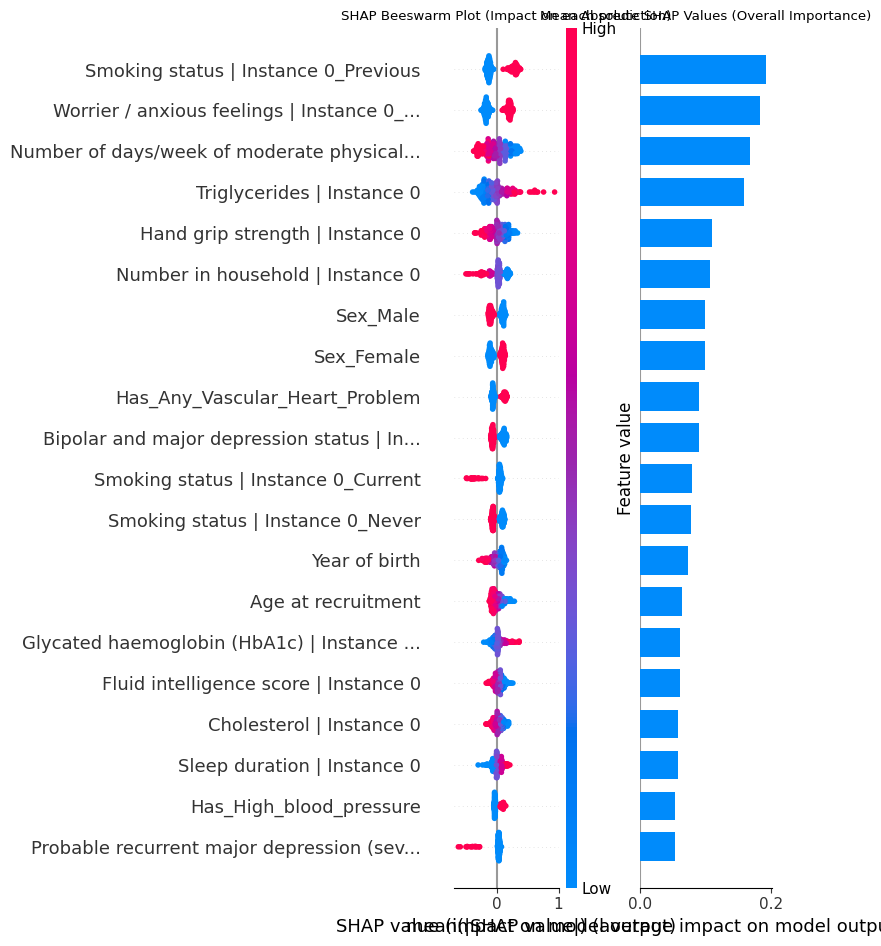


🚀 Starting SHAP Analysis for: best_moe_fulldataset.pth
Model and weights loaded successfully.
Calculating SHAP values... (This may take a moment)

--- SHAP Summary Plots ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


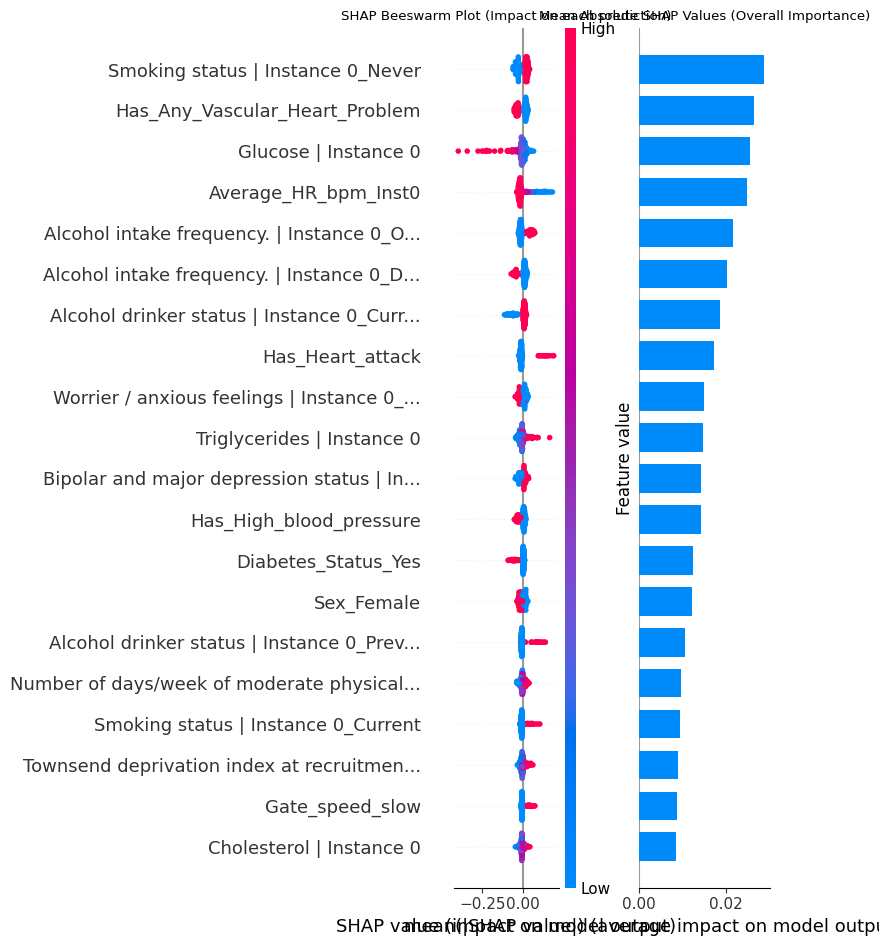


🚀 Starting SHAP Analysis for: best_mop_noninvasivedataset.pth
Model and weights loaded successfully.
Calculating SHAP values... (This may take a moment)

--- SHAP Summary Plots ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


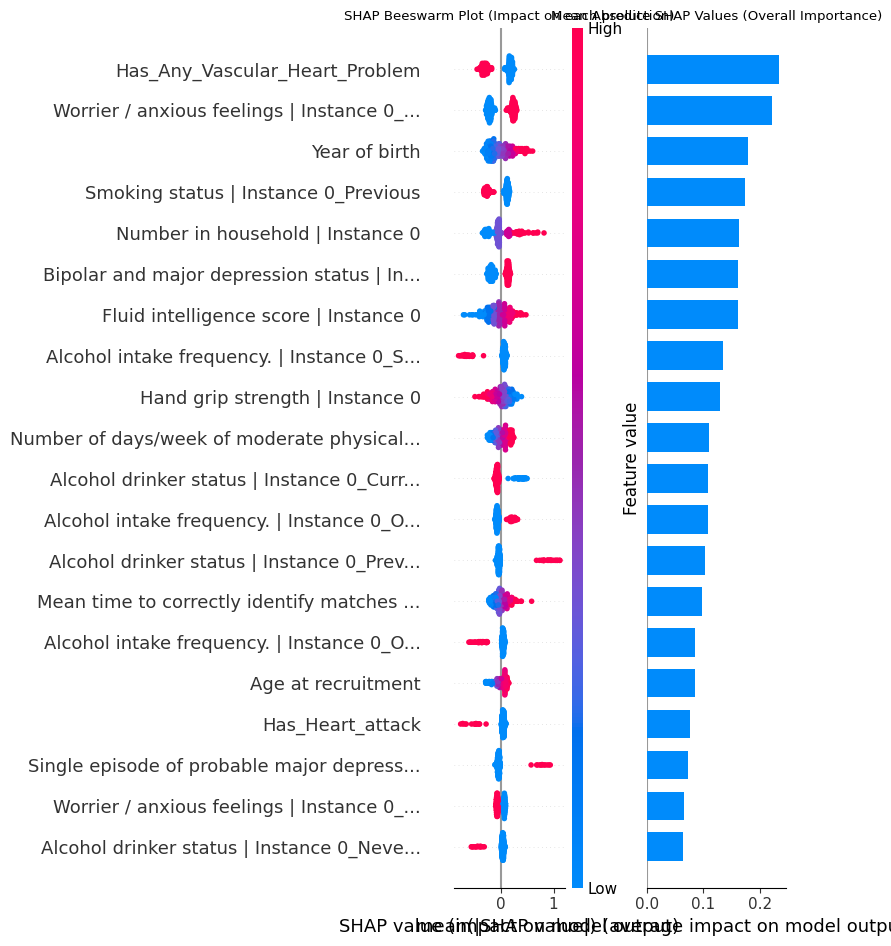


🚀 Starting SHAP Analysis for: best_moe_noninvasivedataset.pth
Model and weights loaded successfully.
Calculating SHAP values... (This may take a moment)

--- SHAP Summary Plots ---


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


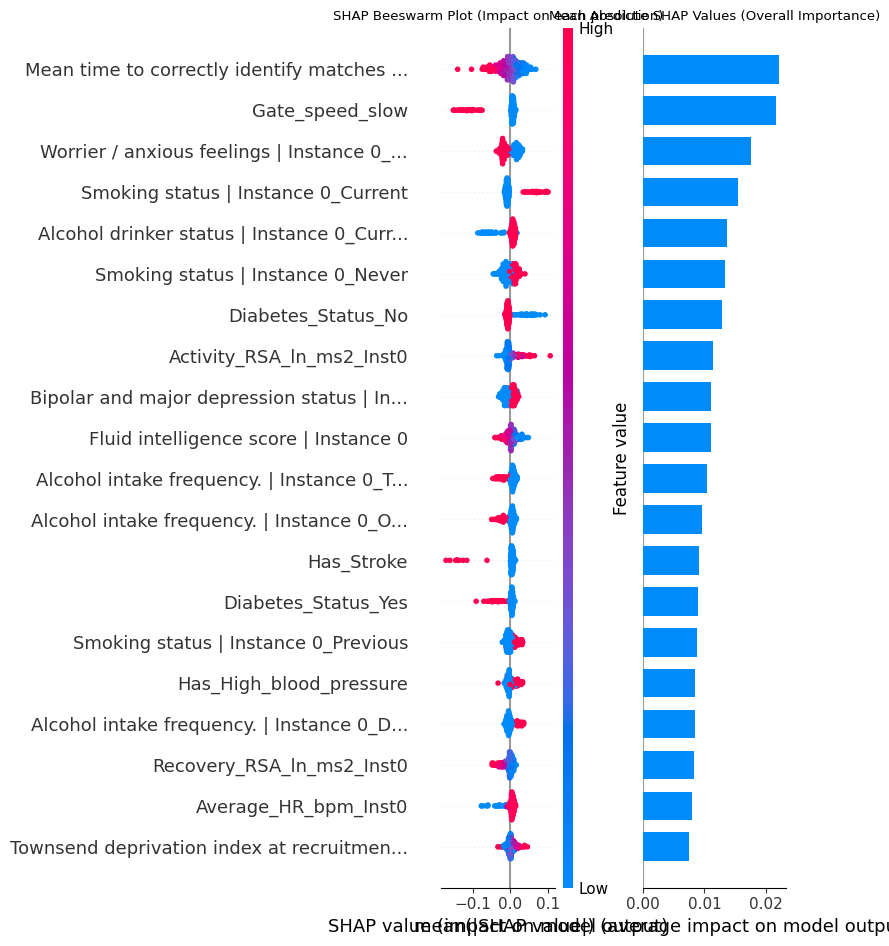

In [24]:
if __name__ == '__main__':
    # --- 1. Load both datasets ---
    X_train_full, X_test_full, feature_names_full = load_and_prepare_data('uk_biobank_dataset.csv')
    X_train_noninvasive, X_test_noninvasive, feature_names_noninvasive = load_and_prepare_data('input_data_noninvasive.csv')

    # --- 2. Define the BEST hyperparameters found for each model ---
    # --- UPDATED with your final winning parameters ---
    
    best_params_mop_full = {
        'input_dim': X_train_full.shape[1], 'output_dim': 2,
        'intermediate_dim': 32, 'layers': ['0,8,16', '0,8,16', '0,8,16']
    }
    
    best_params_moe_full = {
        'input_size': X_train_full.shape[1], 'output_size': 2,
        'num_experts': 3, 'hidden_size': 64, 'k': 2
    }
    
    best_params_mop_noninvasive = {
        'input_dim': X_train_noninvasive.shape[1], 'output_dim': 2,
        'intermediate_dim': 96, 'layers': ['0,8,16', '0,16,32', '0,8,16']
    }

    best_params_moe_noninvasive = {
        'input_size': X_train_noninvasive.shape[1], 'output_size': 2,
        'num_experts': 4, 'hidden_size': 64, 'k': 3
    }

    # --- 3. Run SHAP analysis for each model ---
    
    # Analysis for MoP on the full dataset
    perform_shap_analysis('MoP', best_params_mop_full, 'best_mop_fulldataset.pth',
                          X_train_full, X_test_full, feature_names_full)
                          
    # Analysis for MoE on the full dataset
    perform_shap_analysis('MoE', best_params_moe_full, 'best_moe_fulldataset.pth',
                          X_train_full, X_test_full, feature_names_full)

    # Analysis for MoP on the non-invasive dataset
    perform_shap_analysis('MoP', best_params_mop_noninvasive, 'best_mop_noninvasivedataset.pth',
                          X_train_noninvasive, X_test_noninvasive, feature_names_noninvasive)
                          
    # Analysis for MoE on the non-invasive dataset
    perform_shap_analysis('MoE', best_params_moe_noninvasive, 'best_moe_noninvasivedataset.pth',
                          X_train_noninvasive, X_test_noninvasive, feature_names_noninvasive)


In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import display

# --- This assumes your model files (moe_model.py, mop_model.py) are in the same directory ---
from moe_model import MoE as MoE_raw, MLP as MoE_Expert
from mop_model import MoPModel as MoP_raw, MoPConfig

# --- Helper class to modify the MoE Expert to output raw logits ---
class MoE_Expert_Logits(MoE_Expert):
    def __init__(self, input_size, output_size, hidden_size):
        super().__init__(input_size, output_size, hidden_size)
        self.soft = nn.Identity()

# ===================================================================
# Reusable Functions
# ===================================================================

def load_and_prepare_data(file_path):
    """
    Loads a dataset, splits it into train/val/test sets, and scales the features.
    """
    df = pd.read_csv(file_path, low_memory=False)
    X = df.drop(columns=['Dementia Status'])
    y = df['Dementia Status']
    
    # Replicate the exact data split you used for training
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    # Scale the data in the same way
    scaler = StandardScaler()
    scaler.fit(X_train) # Fit only on training data
    X_test_scaled = scaler.transform(X_test)
    
    return X_test_scaled, y_test.values

def evaluate_model_on_test_set(model_type, model_params, model_path, X_test, y_test):
    """
    Loads a trained PyTorch model and evaluates its performance on the test set.
    """
    print(f"\n--- Evaluating: {model_path} ---")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # 1. Re-create the model with the correct architecture
    if model_type == 'MoP':
        model = MoP_raw(MoPConfig(**model_params))
    else: # MoE
        model = MoE_raw(**model_params)
        model.experts = nn.ModuleList([
            MoE_Expert_Logits(
                input_size=model_params['input_size'],
                output_size=2,
                hidden_size=model_params['hidden_size']
            ) for _ in range(model.num_experts)
        ])
    
    # 2. Load the saved weights
    try:
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model.to(device)
        model.eval()
        print("  ✅ Model and weights loaded successfully.")
    except Exception as e:
        print(f"  ❌ ERROR loading model '{model_path}': {e}")
        return None

    # 3. Evaluate Performance
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test).to(device)

    with torch.no_grad():
        if model_type == 'MoP':
            y_pred_tensor, _, _ = model(X_test_tensor.unsqueeze(1))
            y_pred_tensor = y_pred_tensor.squeeze(1)
        else: # MoE
            y_pred_tensor, _ = model(X_test_tensor)
        
        probas = nn.functional.softmax(y_pred_tensor, dim=1)
        _, predicted = torch.max(probas, 1)
        
        y_true = y_test_tensor.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        y_score = probas[:, 1].cpu().numpy()
        
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0).get('1', {})

        return {
            'Model': f"{model_type}",
            'Dataset': "Full" if "full" in model_path else "Non-Invasive",
            'Accuracy': accuracy_score(y_true, y_pred),
            'ROC-AUC': roc_auc_score(y_true, y_score),
            'F1-Score': report.get('f1-score', 0),
            'Precision': report.get('precision', 0),
            'Recall': report.get('recall', 0),
            'Cohen Kappa': cohen_kappa_score(y_true, y_pred)
        }

# ===================================================================
# Main Execution Block
# ===================================================================

if __name__ == '__main__':
    all_results = []

    # --- 1. Load and Prepare Both Datasets ---
    try:
        X_test_full, y_test_full = load_and_prepare_data('uk_biobank_dataset.csv')
        X_test_noninvasive, y_test_noninvasive = load_and_prepare_data('input_data_noninvasive.csv')
    except FileNotFoundError as e:
        print(f"\n⚠️ ERROR: Could not find a data file: {e}")
        exit()

    # --- 2. Define the Winning Hyperparameters for Each Model ---
    # These must match the architectures of the saved models
    best_params_mop_full = {
        'input_dim': X_test_full.shape[1], 'output_dim': 2,
        'intermediate_dim': 32, 'layers': ['0,8,16', '0,8,16', '0,8,16']
    }
    best_params_moe_full = {
        'input_size': X_test_full.shape[1], 'output_size': 2,
        'num_experts': 3, 'hidden_size': 64, 'k': 2
    }
    best_params_mop_noninvasive = {
        'input_dim': X_test_noninvasive.shape[1], 'output_dim': 2,
        'intermediate_dim': 96, 'layers': ['0,8,16', '0,16,32', '0,8,16']
    }
    best_params_moe_noninvasive = {
        'input_size': X_test_noninvasive.shape[1], 'output_size': 2,
        'num_experts': 4, 'hidden_size': 64, 'k': 3
    }

    # --- 3. Define the list of models to evaluate ---
    models_to_evaluate = [
        ('MoP', best_params_mop_full, 'best_mop_fulldataset.pth', X_test_full, y_test_full),
        ('MoE', best_params_moe_full, 'best_moe_fulldataset.pth', X_test_full, y_test_full),
        ('MoP', best_params_mop_noninvasive, 'best_mop_noninvasivedataset.pth', X_test_noninvasive, y_test_noninvasive),
        ('MoE', best_params_moe_noninvasive, 'best_moe_noninvasivedataset.pth', X_test_noninvasive, y_test_noninvasive)
    ]

    # --- 4. Run the Evaluations ---
    for model_type, params, path, X_data, y_data in models_to_evaluate:
        result = evaluate_model_on_test_set(model_type, params, path, X_data, y_data)
        if result:
            all_results.append(result)
            
    # --- 5. Display the Final Summary Table ---
    if all_results:
        results_df = pd.DataFrame(all_results)
        print("\n\n" + "="*45 + "\n✅ Final Model Performance on Test Sets\n" + "="*45)
        display(results_df)
    else:
        print("\nNo models were successfully evaluated.")



--- Evaluating: best_mop_fulldataset.pth ---
  ✅ Model and weights loaded successfully.

--- Evaluating: best_moe_fulldataset.pth ---
  ✅ Model and weights loaded successfully.

--- Evaluating: best_mop_noninvasivedataset.pth ---
  ✅ Model and weights loaded successfully.

--- Evaluating: best_moe_noninvasivedataset.pth ---
  ✅ Model and weights loaded successfully.


✅ Final Model Performance on Test Sets


,Model,Dataset,Accuracy,ROC-AUC,F1-Score,Precision,Recall,Cohen Kappa
0,MoP,Full,0.633094,0.648447,0.664474,0.615854,0.721429,0.265236
1,MoE,Full,0.485612,0.499948,0.430279,0.486486,0.385714,-0.027288
2,MoP,Non-Invasive,0.500000,0.459058,0.471483,0.504065,0.442857,0.000827
3,MoE,Non-Invasive,0.492806,0.468219,0.653563,0.498127,0.950000,-0.021154
